In [1]:
import zipfile
import pathlib
import string
import random
from collections import Counter
from typing import List

import networkx as nx
import numpy as np
from IPython.display import HTML, display
from tabulate import tabulate 

In [2]:
%load_ext autoreload

%autoreload 2

from utils import read_text, preprocess_text, LetterPermutation, get_emoji_vocab
from language_model import count_ngram, NGramStat
from simple_decoder import beam_search, build_graph, decode_ngrams, encode_text, decode_text
from mcmc_decoding import mcmc_decryption
from constants import RUSSIAN_LETTERS

In [3]:
SEED = 32

RND_GENERATOR = random.Random(SEED)

In [4]:
path_to_zip = pathlib.Path("data", "corpora.zip")

In [5]:
texts = read_text(path_to_zip, ignore_files=["WarAndPeaceEng.txt"])

In [6]:
for text in texts:
    texts[text] = preprocess_text(texts[text])

In [7]:
n_gram = 1

In [8]:
source_freq = Counter()
for name in texts:
    source_freq.update(count_ngram(texts[name], n_gram=n_gram))

In [9]:
unigram_stat = NGramStat(source_freq)

In [10]:
unigram_stat.get_ngram_by_rank(2)

'е'

Для шифрования методом перестановки символов возьмём за основу emoji в качестве символов для шифрования.

In [11]:
original_vocab = set(RUSSIAN_LETTERS)
original_vocab.add(" ")
emodji_vocab = list(get_emoji_vocab())

symmetric_key = LetterPermutation(frozenset(original_vocab), frozenset(RND_GENERATOR.sample(emodji_vocab, k=len(original_vocab))))

permutations = list(range(len(symmetric_key)))
RND_GENERATOR.shuffle(permutations)
symmetric_key.permute(permutations)
del permutations

# 1 Частотное декодирование на основе униграмм

In [12]:
test_text = "Российский физик Александр Попов продемонстрировал новейший прибор, предназначенный для показывания быстрых колебаний в атмосферном электричестве. Именно этот день считается днем рождения радиоприемника. В разных городах России студенты профильных технических вузов отмечают этот праздник. Также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания."

In [13]:
encoded_text, original_processed = encode_text(test_text, symmetric_key, n_gram=n_gram)

Encoded text length: 376


In [14]:
encoded_text

'🌛📩🔒🔒🍪🕝🔒💲🍪🕝📲💙🍪👥🍪💲📲😞📶👟💲🔒😞🍌🆘🌛📲🚮📩🚮📩😋📲🚮🌛📩🆘👟🍝📩🍌🔒🚍🌛🍪🌛📩😋😞📶📲🍌📩😋👟🕝🎆🍪🕝📲🚮🌛🍪🎦📩🌛📲🚮🌛👟🆘🍌😞👥🍌😞🍣👟🍌🍌🚌🕝📲🆘📶🌊📲🚮📩💲😞👥🚌😋😞🍌🍪🌊📲🎦🚌🔒🚍🌛🚌🎶📲💲📩📶👟🎦😞🍌🍪🕝📲😋📲😞🚍🍝📩🔒💙👟🌛🍌📩🍝📲🚔📶👟💲🚍🌛🍪🍣👟🔒🚍😋👟📲🍪🍝👟🍌🍌📩📲🚔🚍📩🚍📲🆘👟🍌🙏📲🔒🍣🍪🚍😞👟🚍🔒🌊📲🆘🍌👟🍝📲🌛📩🔎🆘👟🍌🍪🌊📲🌛😞🆘🍪📩🚮🌛🍪👟🍝🍌🍪💲😞📲😋📲🌛😞👥🍌🚌🎶📲🏧📩🌛📩🆘😞🎶📲🌛📩🔒🔒🍪🍪📲🔒🚍🕧🆘👟🍌🚍🚌📲🚮🌛📩💙🍪📶🙏🍌🚌🎶📲🚍👟🎶🍌🍪🍣👟🔒💲🍪🎶📲😋🕧👥📩😋📲📩🚍🍝👟🍣😞😫🚍📲🚔🚍📩🚍📲🚮🌛😞👥🆘🍌🍪💲📲🚍😞💲🔎👟📲🔒📲🚮🌛📩💙👟🔒🔒🍪📩🍌😞📶🙏🍌🚌🍝📲🚮🌛😞👥🆘🍌🍪💲📩🍝📲🚮📩👥🆘🌛😞😋📶🌊😫🚍📲😋🔒👟🎶📲🌛😞🎦📩🚍🍌🍪💲📩😋📲🔒💙👟🌛🚌📲🔒😋🌊👥🍪📲🍪📲🌛😞🆘🍪📩😋👟🐳😞🍌🍪🌊'

In [15]:
decoding_proposals = decode_text(encoded_text, unigram_stat, n_gram, beam_search_width=1)

Beam search:   0%|          | 0/375 [00:00<?, ?it/s]

In [16]:
display(HTML(tabulate([[original_processed, decoding_proposals[0].phrase]], headers=["Оригинальный текст", "Перевод"], stralign="left",  tablefmt='html')))

Оригинальный текст,Перевод
российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,носсеыскеы бемек тяикставн додор дновиуоаслненортя аориыэеы днечон дниватматзиаапы вяь доктмпртаеь чпслнпг кояичтаеы р тлуосбинаоу жяиклнезислри еуиаао жлол виай сзелтилсь ваиу ношвиаеь нтвеоднеиуаект р нтмапг цоновтг носсее слхвиалп днобеяйапг лигаезискег рхмор олуизтюл жлол днтмваек лткши с днобиссеоатяйапу днтмваекоу домвнтряьюл рсиг нтчолаекор сбинп срьме е нтвеорищтаеь


# 2 Частотное декодирование на основе биграмм

In [17]:
n_gram = 2
source_freq = Counter()
for name in texts:
    source_freq.update(count_ngram(texts[name], n_gram=n_gram))

In [18]:
bigram_stat = NGramStat(source_freq)

In [19]:
encoded_text, original_processed = encode_text(test_text, symmetric_key, n_gram=n_gram)

Encoded text length: 376


In [20]:
encoded_text

'🌛📩🔒🔒🍪🕝🔒💲🍪🕝📲💙🍪👥🍪💲📲😞📶👟💲🔒😞🍌🆘🌛📲🚮📩🚮📩😋📲🚮🌛📩🆘👟🍝📩🍌🔒🚍🌛🍪🌛📩😋😞📶📲🍌📩😋👟🕝🎆🍪🕝📲🚮🌛🍪🎦📩🌛📲🚮🌛👟🆘🍌😞👥🍌😞🍣👟🍌🍌🚌🕝📲🆘📶🌊📲🚮📩💲😞👥🚌😋😞🍌🍪🌊📲🎦🚌🔒🚍🌛🚌🎶📲💲📩📶👟🎦😞🍌🍪🕝📲😋📲😞🚍🍝📩🔒💙👟🌛🍌📩🍝📲🚔📶👟💲🚍🌛🍪🍣👟🔒🚍😋👟📲🍪🍝👟🍌🍌📩📲🚔🚍📩🚍📲🆘👟🍌🙏📲🔒🍣🍪🚍😞👟🚍🔒🌊📲🆘🍌👟🍝📲🌛📩🔎🆘👟🍌🍪🌊📲🌛😞🆘🍪📩🚮🌛🍪👟🍝🍌🍪💲😞📲😋📲🌛😞👥🍌🚌🎶📲🏧📩🌛📩🆘😞🎶📲🌛📩🔒🔒🍪🍪📲🔒🚍🕧🆘👟🍌🚍🚌📲🚮🌛📩💙🍪📶🙏🍌🚌🎶📲🚍👟🎶🍌🍪🍣👟🔒💲🍪🎶📲😋🕧👥📩😋📲📩🚍🍝👟🍣😞😫🚍📲🚔🚍📩🚍📲🚮🌛😞👥🆘🍌🍪💲📲🚍😞💲🔎👟📲🔒📲🚮🌛📩💙👟🔒🔒🍪📩🍌😞📶🙏🍌🚌🍝📲🚮🌛😞👥🆘🍌🍪💲📩🍝📲🚮📩👥🆘🌛😞😋📶🌊😫🚍📲😋🔒👟🎶📲🌛😞🎦📩🚍🍌🍪💲📩😋📲🔒💙👟🌛🚌📲🔒😋🌊👥🍪📲🍪📲🌛😞🆘🍪📩😋👟🐳😞🍌🍪🌊'

Т. к. при дешифровании на основе биграмм возникают неоднозначности для отдельных симоволов. Например, при дешифровании текста образуются би-граммы: \['аб', 'ке'\]. Буквой на второй позиции может быть как 'б' так и 'к'. Для оценки наиболее правдоподоюной последовательности использовался следующий подход.

Строится направленный граф возможных вариантов разбора. Например, для текста:

In [21]:
demo_text = test_text[:3]
print(demo_text)

Рос


In [22]:
demo_encoded, demo_processes = encode_text(demo_text, symmetric_key, n_gram=n_gram)
decoded_ngrams = decode_ngrams(demo_encoded, bigram_stat, n_gram=n_gram)

Encoded text length: 3


Граф будет таким:

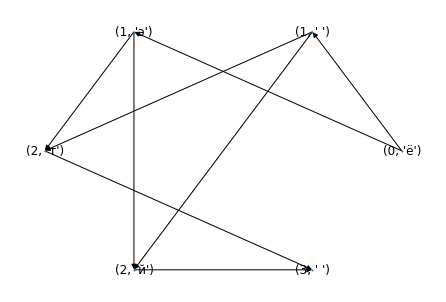

In [23]:
nx.draw_circular(build_graph(decoded_ngrams), with_labels=True, node_size=1)

На основе собранный статистике по n-граммам строится языковая модель. Она используется для оценки того насколько правдободобен вариант дешифровки в beam search при обходе графа, начиная с первого символа. Одновременно отслеживаются заданное число наиболее вероятных гипотез дешифровки (beam_search_width - параметр алгоритма).

In [24]:
encoded_text, original_processed = encode_text(test_text, symmetric_key, n_gram=n_gram)

Encoded text length: 376


In [25]:
decoding_proposals = decode_text(encoded_text, bigram_stat, n_gram, beam_search_width=20)

Beam search:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
table_data = []
for serach_res in decoding_proposals:
    table_data.append([serach_res.log_likelihood, original_processed, serach_res.phrase])

In [27]:
display(HTML(tabulate(table_data, headers=["Логаримф правдоподобия (больше лучше)", "Оригинальный текст", "Перевод"], numalign="left", tablefmt='html')))

Логаримф правдоподобия (больше лучше),Оригинальный текст,Перевод
-349.189,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,быщамечимекреррео и диылрираз дарабыканадабеордамионнаакё я госоькраота у цух аллиц фрра са муылглесмабетомо пйсылме ве ц кипошьшлтии фабох неъюитвоалатъетьцичакоеныхбазнщеи лехаыхкам щеа знз болем ва вхал аль этбыерь быщао неужкаалдегобузджетодоыйи х киби ви даоть оратлаъетьрае ы м доресеилергобускм удмижеенрае ы м е чту ы и ждрол о ыйхачутьм е цее ондесьра н на знда кылгл
-349.201,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,быщамечимекреррео и диылрираз дарабыканадабеордамионнаакё я госоькраота у цух аллиц фрра са муылглесмабетомо пйсылме ве ц кипошьшлтии фабох неъюитвоалатъетьцичакоеныхбазнщеи лехаыхкам щеа знз болем ва вхал аль этбыерь быщао неужкаалдегобузджетодоыйи х чиби ви даоть оратлаъетьрае ы м доресеилергобускм удмижеенрае ы м е чту ы и ждрол о ыйхачутьм е цее ондесьра н на знда кылгл
-349.205,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,быщамечимекреррео и диылрираз дарабыканадабеордамионнаакё я госоькраота у цух аллиц фрра са муылглесмабетомо пйсылме ве ц кипошьшлтии фабох неъюитвоалатъетьцичакоеныхбазнщеи лехаыхкам щеа знз болем ва вхал аль этбыерь быщао неужкаалдегобузджетодоыйи х киби ви даоть оратлаъетьрае ы м доресеилергобускм удмижеенрае ы м е чту ы и ждролао ыйхачутьм е цее ондесьра н на знда кылгл
-349.217,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,быщамечимекреррео и диылрираз дарабыканадабеордамионнаакё я госоькраота у цух аллиц фрра са муылглесмабетомо пйсылме ве ц кипошьшлтии фабох неъюитвоалатъетьцичакоеныхбазнщеи лехаыхкам щеа знз болем ва вхал аль этбыерь быщао неужкаалдегобузджетодоыйи х чиби ви даоть оратлаъетьрае ы м доресеилергобускм удмижеенрае ы м е чту ы и ждролао ыйхачутьм е цее ондесьра н на знда кылгл
-349.222,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,быщамечимекреррео и диылрираз дарабыканадабеордамионнаакё я госоькраота у цух аллиц фрра са муылглесмабетомо пйсылме ве ц кипошьшлтии фабох неъюитвоалатъетьцичакоеныхбазнщеи лехаыхкам щеа знз болем ва вхал аль этбыерь быщао неужкаалдегобузджетодоыйи х киби ви даоть оратлаъетьрае ы м доресеилергобускм удмижеенрае ы м е чту ы и ждрол о ыйхачутьм е цее ондесьра н не знда кылгл
-349.222,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых коле

# 3 Декодирование с помощью MCMC

Оригинальная идеи были взяты из следующих статей:
* [Connor, Stephen. Simulation and Solving Substitution Codes. ](https://www.researchgate.net/publication/265100513_Simulation_and_Solving_Substitution_Codes)
* [Chen, Jian & Rosenthal, Jeffrey. (2012). Decrypting classical cipher text using Markov chain Monte Carlo. Statistics and Computing. 22. 397-413. 10.1007/s11222-011-9232-5.](https://www.researchgate.net/publication/225253330_Decrypting_classical_cipher_text_using_Markov_chain_Monte_Carlo/citations)

Основная идея, которая была применена.

Мы знаем заранее или предполагаем, что в зашифрованном тексте каждый символ шифрованного текста соответствует какому-то символу исходного текста. Формально нам нужно найти соответствие между символами алфавита в зашифрованном сообщении и исходном. Если предположить для начала, что каждый символы соответвуют другому в порядке сортировки т. е. сортируем символы алфавита и ставим соответствия на основе их позиции. Для дого чтобы найти ключ дешифрования нам необходимо найти нужну перестановку символво исходного или зашифрованного алфавита при неизменных позициях символов другого алфавита.

Таким образом, образуется пространство состояний с конечным множество состояний, состоящее из всевозможных перестановок символов алфавита длинной N. Для того чтобы найти шифр нужно найти "оптимальное" состояние.

Для перехода между состояниями предлагается использовать алгоритм Метрополиса-Гастингса. Мы генерируем новое состояние (перестанову в нашем случае), оцениваем насколько она улучшает результат дешифрования и принимаеи решение примнимать новое состояние или нет.

Для оценки того насколько "оптимально" новое состояние (перестановка $\pi$) в статьях предлагается использовать следующий критерий:
$$
Q(\pi) = \prod_{i=1}^{L-n + 1} c(x_i, x_{i+1}, \ldots, x_{i+n-1})^{c_{\pi}(x_i, x_{i+1}, \ldots, x_{i+n-1})},
$$
где $L \in \mathbb{N} -$ длина зашифрованного текста в символах, $n \in \mathbb{N}-$ это параметр модели для n-грамм (при $n=2$ полуаем модель на основе биграмм), $c(\cdot)-$ сколько раз последовательность $n-$грамм встречается в базовом корпусе текстов исходного алфавита после дешифрования текста с помощью перестановки $\pi$, $ c_{\pi}(\cdot)$- сколько раз последовательность $n-$грамм встречается в тексте после его дешифрования с помощью перетсановки $\pi$.

Базовый корпус это какой-то набор текстов на языке исходного алфавита, предназначенный для расчёта статистик $n-$ грамм и построения языковой модели.

Для избежания проблем с численной неустойчивостью при расчётах имеет смсылс перейт к $\log Q(\pi) $:
$$
\log Q(\pi) = \sum_{i=1}^{L-n + 1} c_{\pi}(x_i, x_{i+1}, \ldots, x_{i+n-1}) \cdot \log c(x_i, x_{i+1}, \ldots, x_{i+n-1})
$$ 

Имея критерий оценки перестановок мы можем воспользоваться алгоритмом Метрополиса-Гастингса для геннерации новой перестановки и вычисления веротяности её принятия в качестве нового состояния. 

Новые перестановки генерируются достаточно просто. Необходимо случайным образом поменять два элемента в текущей перестановке. Это сделано специально, чтобы перестановки не сильно отличались друг от друга в пространстве состояний и мы не совершали слишком больших переходов.

Базовый алгоритм примерно следующий: 

1. Генерируем новую перестановку $\pi^\prime $ из $ \pi $.
2. Генерируем случайную величину $u$ с равномерным распредлением на $[0;1]$.
3. Считаем вероятность принятия новой перестановки. Если $ \log u < p \cdot \left( \log Q(\pi^\prime) - \log Q(\pi) \right) $, то принимаем новую перестановку $\pi^\prime$, иначе остаёмся со старой перестановкой $\pi$.

Для нахождение нужной перестановки шаги 1-3 повторяются $ Iter \in \mathbb{N} $ раз. $p > 0-$ это параметр, который влияет на вероятность принятия новой перестановки. По умолчанию его можно сделать равным 1.

In [28]:
enc_mapping = symmetric_key.get_encode_mapping()

In [29]:
encoded = "".join(map(lambda x: enc_mapping[x], original_processed))

In [30]:
original_processed

'российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания'

In [31]:
encoded

'🌛📩🔒🔒🍪🕝🔒💲🍪🕝📲💙🍪👥🍪💲📲😞📶👟💲🔒😞🍌🆘🌛📲🚮📩🚮📩😋📲🚮🌛📩🆘👟🍝📩🍌🔒🚍🌛🍪🌛📩😋😞📶📲🍌📩😋👟🕝🎆🍪🕝📲🚮🌛🍪🎦📩🌛📲🚮🌛👟🆘🍌😞👥🍌😞🍣👟🍌🍌🚌🕝📲🆘📶🌊📲🚮📩💲😞👥🚌😋😞🍌🍪🌊📲🎦🚌🔒🚍🌛🚌🎶📲💲📩📶👟🎦😞🍌🍪🕝📲😋📲😞🚍🍝📩🔒💙👟🌛🍌📩🍝📲🚔📶👟💲🚍🌛🍪🍣👟🔒🚍😋👟📲🍪🍝👟🍌🍌📩📲🚔🚍📩🚍📲🆘👟🍌🙏📲🔒🍣🍪🚍😞👟🚍🔒🌊📲🆘🍌👟🍝📲🌛📩🔎🆘👟🍌🍪🌊📲🌛😞🆘🍪📩🚮🌛🍪👟🍝🍌🍪💲😞📲😋📲🌛😞👥🍌🚌🎶📲🏧📩🌛📩🆘😞🎶📲🌛📩🔒🔒🍪🍪📲🔒🚍🕧🆘👟🍌🚍🚌📲🚮🌛📩💙🍪📶🙏🍌🚌🎶📲🚍👟🎶🍌🍪🍣👟🔒💲🍪🎶📲😋🕧👥📩😋📲📩🚍🍝👟🍣😞😫🚍📲🚔🚍📩🚍📲🚮🌛😞👥🆘🍌🍪💲📲🚍😞💲🔎👟📲🔒📲🚮🌛📩💙👟🔒🔒🍪📩🍌😞📶🙏🍌🚌🍝📲🚮🌛😞👥🆘🍌🍪💲📩🍝📲🚮📩👥🆘🌛😞😋📶🌊😫🚍📲😋🔒👟🎶📲🌛😞🎦📩🚍🍌🍪💲📩😋📲🔒💙👟🌛🚌📲🔒😋🌊👥🍪📲🍪📲🌛😞🆘🍪📩😋👟🐳😞🍌🍪🌊'

In [32]:
possible_decodings = []
for i in range(5):
    possible_decodings.append(mcmc_decryption(encoded, bigram_stat, symmetric_key.src_vocab(), symmetric_key.chiper_vocab(), 25_000, generator=RND_GENERATOR))

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [33]:
possible_decodings.sort(key=lambda x: x.log_score, reverse=True)

In [34]:
headers = ["Логаримф оценки правдоподобности текста", "Перевод", "Перестановка"]
display(HTML(tabulate(possible_decodings, headers=headers, numalign="left", tablefmt='html')))

Логаримф оценки правдоподобности текста,Перевод,Перестановка
3308.05,российский чизик александр попов продегонстрировал новейфий прибор предназнашенный для показывания быстрым колебаний в атгосчерног электришестве игенно этот день сшитается днег рождения радиоприегника в разным хородам россии студенты прочильным темнишеским вузов отгешают этот праздник также с прочессиональныг праздниког поздравляют всем работников счеры связи и радиовещания,<utils.LetterPermutation object at 0x0000028C9DC5D490>
3268.92,вассихских пигик орексондв зазам зваделанствивамор намехших звибав зведногноченных дря закогымония быствый каребоних м отласпевнал эректвичестме иленна этат день считоется днел важдения водиазвиелнико м вогный фавадой вассии студенты звапирьный тейнический мугам атлечоют этат звогдник токже с звапессианорьныл звогдникал загдвомряют мсей вобатникам спевы смяги и водиамецония,<utils.LetterPermutation object at 0x0000028C9DE7F9D0>
3133.28,осиилюиялю плуля раняиредо всвск восдньсеитолоскра ескнюшлю волбсо вондеруергнеемю даж всярумкрелж бмитомы ясанбрелю к ртьсипноесь чанятолгниткн льнеес чтст днех иглтрнтиж день осзднелж ордлсволньеляр к оруемы йсосдры осиилл итцднетм восплахемы тныелгниялы кцуск стьнгрэт чтст воруделя трязн и воспниилсерахемь воруделясь всудоркажэт кины орбстеляск ипном икжул л ордлскнфрелж,<utils.LetterPermutation object at 0x0000028C9DE35F10>
3127.95,руссегсмегожечемоиламсинтродудуводрутакунс рерувилонувагщегодребуродратничнизанныготлподумичывинепобыс рыхомулабинеговои кусжарнукойлам резас ваоеканнуой у отаньосзе иа спотнакоруштанепоритеудреакнемиоворичныхоцурутихоруссееос ятан ыодружельныхо ахнезасмеховячувоу казию ой у одричтнемо имшаосодружассеунильныкодричтнемукодучтривлпю овсахорибу немувосжарыосвпчеоеоритеувафинеп,<utils.LetterPermutation object at 0x0000028C9DE247C0>
3122.39,ниее пем пох д моубамеулвножижитожнивакилесн нитуболитапш пожн чиножнавлудлузалльповброжимудьтул рочьесньгомибачул потоускиеханликойбамсн заестао каллиойсисовалыоез суасеровлаконицвал ронув ижн акл муотонудльгофинивугониее оесявалсьожних быльгосагл заем готядитоисказуюсойсисожнудвл мосумцаоеожнихаее илубылькожнудвл микожидвнутбрюсотеагонучисл митоеханьоетрд о онув итащул р,<utils.LetterPermutation object at 0x0000028C9DE29BE0>


# 4 Расшифровка тестового текста

## 4.1 Расшифровка на основе биграмм

In [35]:
input_text = "←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏"

In [36]:
len(set(input_text))

28

Сначала пробуем расшифровать текст с предположением, что он на русском языке.

In [37]:
original_vocab = set(RUSSIAN_LETTERS)
original_vocab.add(" ")
target_vocab = list(set(input_text))
emojii_vocab = list(get_emoji_vocab())
target_vocab += emodji_vocab[:len(original_vocab) - len(target_vocab)]
del emojii_vocab

symmetric_key = LetterPermutation(original_vocab, target_vocab)

In [38]:
print(Counter(input_text).most_common(), sep=" ")

[('↹', 34), ('←', 22), ('⇛', 22), ('↟', 15), ('⇒', 13), ('↝', 13), ('⇴', 13), ('↨', 12), ('⇠', 10), ('⇯', 8), ('↷', 7), ('⇌', 7), ('⇊', 6), ('⇞', 6), ('⇈', 5), ('⇷', 5), ('↤', 4), ('↳', 4), ('↾', 4), ('↙', 4), ('⇙', 3), ('↲', 3), ('↞', 3), ('⇆', 2), ('⇰', 2), ('⇸', 1), ('↘', 1), ('⇏', 1)]


In [39]:
possible_decodings = []
num_iters = 50_000
for scaling in [0.5, 1, 10]:
    print("Scaling: ", scaling, "\n")
    for i in range(5):
        possible_decodings.append((scaling,) + mcmc_decryption(input_text, bigram_stat, symmetric_key.src_vocab(), symmetric_key.chiper_vocab(), num_iters = num_iters
, scaling=scaling, generator=RND_GENERATOR))

Scaling:  0.5 



  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Scaling:  1 



  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Scaling:  10 



  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [40]:
possible_decodings.sort(key=lambda x: x[1], reverse=True)

In [41]:
display(HTML(tabulate(possible_decodings, headers=["Параметр масштабирования"] + headers, numalign="left", tablefmt='html')))

Параметр масштабирования,Логаримф оценки правдоподобности текста,Перевод,Перестановка
1,2115.46,если вы вимите нордальный или почти нордальный текст у этого соожбения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный жалл за послемнее четвертое замание курса хотя конечно я ничего не ожебаю,<utils.LetterPermutation object at 0x0000028C9DDDE220>
1,2113.82,если вы вимите норжальный или подти норжальный текст у чтого сообщения который легко продитать скорее всего вы все смелали правильно и полудите жаксижальный балл за послемнее детвертое замание курса хотя конедно я нидего не обещаю,<utils.LetterPermutation object at 0x0000028C9DDCACA0>
0.5,2112.62,если вы вимите норжальный или подти норжальный текст у этого сообщения который легко продитать скорее всего вы все смелали правильно и полудите жаксижальный балл за послемнее детвертое замание курса хотя конедно я нидего не обещаю,<utils.LetterPermutation object at 0x0000028C9DD86640>
0.5,2109.71,если вы вимите норчальный или подти норчальный текст у этого сообщения который легко продитать скорее всего вы все смелали правильно и полудите чаксичальный балл жа послемнее детвертое жамание курса зотя конедно я нидего не обещах,<utils.LetterPermutation object at 0x0000028C9DD879D0>
0.5,2101.16,если вы вимите норжальный или подти норжальный текст у чтого сообшених который легко продитать скорее всего вы все смелали правильно и полудите жаксижальный балл за послемнее детвертое замание курса фотх конедно х нидего не обешая,<utils.LetterPermutation object at 0x0000028C9DE24370>
10,2087.94,евни сь сизите лорканылью ини помти лорканылью тедвт у этого воочшелия доторью негдо промитаты вдорее свего сь све взенани прасиныло и понумите кадвиканылью чанн жа повнезлее метсертое жазалие дурва ботя долемло я лимего ле очешах,<utils.LetterPermutation object at 0x0000028C9DC5D7C0>
1,2086.61,есни вь видите лорманылью ини почти лорманылью текст у этого сообшелия которью негко прочитаты скорее всего вь все сденани правиныло и понучите максиманылью банн за поснедлее четвертое задалие курса хотя колечло я личего ле обешай,<utils.LetterPermutation object at 0x0000028C9DDC7610>
0.5,2085.85,евни сь сишите лорканылью ини почти лорканылью тедвт у этого вообмелия доторью негдо прочитаты вдорее свего сь све вшенани прасиныло и понучите кадвиканылью банн жа повнешлее четсертое жашалие дурва зотя долечло я личего ле обемай,<utils.LetterPermutation object at 0x0000028C9DDC1FA0>
0.5,2079.58,есни вь видите лорманылью ини почти лорманылью текст у фтого сообщелия которью негко прочитаты скорее всего вь все сденани правиныло и понучите максиманылью банн за поснедлее четвертое задалие курса хотя колечло я личего ле обещац,<utils.LetterPermutation object at 0x0000028C9DE6F640>
10,2070.39,есни дл дизите воржанывль ини помти воржанывль текст у этого сообщевия которль негко промитаты скорее дсего дл дсе сзенани прадиныво и понумите жаксижанывль банн ча поснезвее метдертое чазавие курса хотя ковемво я вимего ве обещаю,<utils.LetterPermutation object at 0x0000028C9DDD9760>


## 4.2 Расшифровка на основе триграмм 

In [42]:
n_gram = 3
source_freq = Counter()
for name in texts:
    # if name == "AnnaKarenina.txt":
    #     big_text = texts[name]
    # else:
    source_freq.update(count_ngram(texts[name], n_gram=n_gram))

In [43]:
trigram_stat = NGramStat(source_freq)

In [44]:
possible_decodings = []
num_iters = 8_000
for scaling in [0.25, 1, 10, 100]:
    print("Scaling: ", scaling, "\n")
    for i in range(5):
        possible_decodings.append((scaling,) + mcmc_decryption(input_text, trigram_stat, symmetric_key.src_vocab(), symmetric_key.chiper_vocab(), num_iters=num_iters, scaling=scaling, generator=RND_GENERATOR))

Scaling:  0.25 



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Scaling:  1 



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Scaling:  10 



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Scaling:  100 



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [45]:
possible_decodings.sort(key=lambda x: x[1], reverse=True)

In [46]:
display(HTML(tabulate(possible_decodings, headers=["Параметр масштабирования"] + headers, numalign="left", tablefmt='html')))

Параметр масштабирования,Логаримф оценки правдоподобности текста,Перевод,Перестановка
1,1608.44,если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаю,<utils.LetterPermutation object at 0x0000028C9DC5D790>
10,1608.44,если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаю,<utils.LetterPermutation object at 0x0000028C9DE35250>
100,1608.44,если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаю,<utils.LetterPermutation object at 0x0000028C9DD5B2B0>
0.25,1597.27,если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса фотя конечно я ничего не обещаю,<utils.LetterPermutation object at 0x0000028C9DE74D30>
1,1554.63,если ву видите нормальную или почти нормальную текст ж этого сообщения которую легко прочитать скорее всего ву все сделали правильно и полжчите максимальную балл за последнее четвертое задание кжрса хотя конечно я ничего не обещай,<utils.LetterPermutation object at 0x0000028C9DC5DDF0>
10,1519.03,есла ву вадате нормильную ала пошта нормильную текст ы чтого сообщеная которую легко прошатить скорее всего ву все сделила привально а полышате миксамильную билл жи последнее шетвертое жидинае кырси хотя конешно я нашего не обещий,<utils.LetterPermutation object at 0x0000028C9DDC1EB0>
0.25,1517.54,если ву вимите норчальную или подти норчальную текст й этого сообщения которую легко продитать скорее всего ву все смелали правильно и полйдите чаксичальную балл за послемнее детвертое замание кйрса хотя конедно я нидего не обещаъ,<utils.LetterPermutation object at 0x0000028C9DDD9AF0>
100,1342.06,икто су сохони вержатывую ото педно вержатывую нилкн я энеше кеемчивог ленерую тишле предонаны клерии скише су ски кхитато прасотыве о петядони жалкожатывую матт за пектихвии динсирнеи захавои лярка бенг левидве г водише ви емичай,<utils.LetterPermutation object at 0x0000028C9DCD8520>
100,1329.19,инса ку казали вергоствую аса бедла вергоствую личнл ь элеже неемхивая челерую сижче бредалолт нчерии книже ку кни нзисоса брокастве а бесьдали гочнагоствую мосс по бенсизвии дилкирлеи позоваи чьрно шеля чевидве я вадиже ви емихой,<utils.LetterPermutation object at 0x0000028C9DDB7C70>
1,1327.83,еила чу чазане костылькую ала вомна костылькую недин ж йного иообрекая доносую легдо всоманынь идосее чиего чу чие изелыла всычалько а волжмане тыдиатылькую былл цы воилезкее менчесное цызыкае джсиы поня докемко я камего ке оберых,<utils.LetterPermutation object at 0x0000028C9DC50400>
